# 金融算法AlwaysHalf
## 算法思路
现金资金始终占总资金的一半
设股价为p，股票当前持有数量为$V,V=nu$,通常n为手数，u是每手股票数，通常为100。现金金额为C，总资产为S  
1. 买入策略,(当天买完一手后，现金仍然大于等于一半)
$$
C-pu \ge n \cdot pu+pu
$$
2. 卖出策略,(当天卖出一手后，股金仍然大于等于一半)
$$
n \cdot pu -pu \ge C+pu
$$
总结
$$
\begin{equation}
Action(p)=
\begin{cases}
+1 &,&   when \ p \le \frac{C}{(n+2)u} \\
-1 &,&   when \ p \ge \frac{C}{(n-2)u}
\end{cases}
\end{equation}
$$

## 数据获取
我们以股票代码为000001的平安银行为例

In [258]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
data=pd.read_csv('000001.csv',index_col=0)

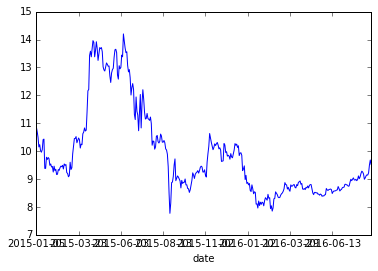

In [259]:
data=data.sort_index()
data['close'].plot()

In [274]:
data.head()

,open,high,close,low,volume,amount
date,,,,,,
2015-01-05,10.85,11.04,10.87,10.58,286043648.0,4.565388e+09
2015-01-06,10.75,11.12,10.70,10.55,216642144.0,3.453446e+09
2015-01-07,10.55,10.74,10.50,10.38,170012064.0,2.634796e+09
2015-01-08,10.51,10.56,10.15,10.11,140771424.0,2.128003e+09
2015-01-09,10.11,10.76,10.23,9.98,250850016.0,3.835378e+09


In [261]:
print 'averages'
for v in data.columns:
    print v,': ' ,np.average(data[v])

averages
open :  9.87677581864
high :  10.0334760705
close :  9.88168765743
low :  9.7237279597
volume :  110506006.491
amount :  1518951970.52


## 数据类型

- CapRecord维护账面资金分布  
- CapBook维护当前账面资金分布，资金历史，交易历史
- Trade维护交易信息

In [330]:
class CapRecord():
    '''
    Record the capital distribution between stock and cash,
    Current day, stock price, stock unit, stock volume
    '''
    def __init__(self,date,price,unit,vol,cash):
        self.date=date
        self.price=price
        self.unit=unit
        self.vol=vol
        self.cash=cash
       
    
    def trade(self,trdate,trprice,trvol,closeprice):
        self.date=trdate
        self.vol=self.vol+trvol
        self.cash=self.cash-trvol*trprice
        self.price=closeprice
    
    def update(self,trdate,closeprice):
        self.date=trdate
        self.price=closeprice
    
    
    def toDataFrame(self):
        'convert capRecord to dataFrame'
        stock=self.price*self.vol
        total=cash+stock
        colnames=np.array(['price','unit','vol','cash','stock','total'])
        data=[[self.price,self.unit,self.vol,self.cash,stock,total]]
        df=pd.DataFrame(data,columns=colnames,index=[self.date])
        return df
    
    def getBuyPrice(self):
        return self.cash/(self.vol+self.unit*2)
    
    def getSellPrice(self):
        'never sell when just 2 units'
        if self.vol > self.unit*2:
            return self.cash/(self.vol-self.unit*2)
        else:
            return self.price*2

In [331]:
class Trade():
    '''
    Record the trade date, volume, price
    '''
    def __init__(self,trdate,trprice,trvol):
        self.trdate=trdate
        self.trprice=trprice
        self.trvol=trvol
    
    def toDataFrame(self):
        'convert the trade to dataFrame'
        colnames=np.array(['trdate','trprice','trvol'])
        data=[[self.trdate,self.trprice,self.trvol]]
        df=pd.DataFrame(data,columns=colnames,index=[0])
        return df

In [333]:
class CapBook():
    def __init__(self, rec):
        self.curRec=rec
        self.histBook=rec.toDataFrame()
        self.tradeCount=0
        self.initTotal=rec.cash+rec.price*rec.vol
    
    def trade(self,trdate,trprice,trvol,closeprice):
        self.curRec.trade(trdate,trprice,trvol,closeprice)
        tmp=self.curRec.toDataFrame()
        self.histBook=self.histBook.append(tmp)
        
        trade=Trade(trdate,trprice,trvol)
        tradedf=trade.toDataFrame()
        if self.tradeCount==0:
            self.histTrades=tradedf
        else:
            self.histTrades=self.histTrades.append(tradedf,ignore_index=True)
        self.tradeCount=self.tradeCount+1
    
    def update(self,trdate,closeprice):
        self.curRec.update(trdate,closeprice)
        tmp=self.curRec.toDataFrame()
        self.histBook=self.histBook.append(tmp)

## 初始化
获取第一天的金额，买入40手，并设置对应的现金池

In [369]:
price_start= data.iloc[0][0]
date_start=data.index[0]
price=price_start
unit=100
vol=40*unit
cash=price*vol
cr=CapRecord(date_start,price,unit,vol,cash)
cb=CapBook(cr)

## 执行半仓策略（AlwaysHalf）

In [370]:
for index,row in data['2015-01-06':'2015-11-09'].iterrows():
    low=row['low']
    high=row['high']
    close=row['close']
    buyPrice= cb.curRec.getBuyPrice()
    sellPrice=cb.curRec.getSellPrice()
    trdate=index
    tradeflag=False
    if low< buyPrice:
        cb.trade(trdate=trdate,trprice=buyPrice,trvol=cb.curRec.unit,closeprice=close)
        tradeflag=True
    if high> sellPrice:
        cb.trade(trdate=trdate,trprice=buyPrice,trvol=-cb.curRec.unit,closeprice=close)
        tradeflag=True
    if tradeflag == False:
        cb.update(trdate=trdate,closeprice=close)
        
    
    

## 结果分析

In [371]:
cb.histTrades.head()

,trdate,trprice,trvol
0,2015-01-08,10.333333,100
1,2015-01-12,9.852713,100
2,2015-01-15,9.404863,-100
3,2015-01-19,9.842298,100
4,2015-01-20,9.394921,100


In [372]:
hbook=cb.histBook.copy()
hbook=hbook.sort_index()
hbook['costprice']= (cb.initTotal-hbook['cash'])/hbook['vol']
hbook['stock2']=(hbook['total']-hbook['cash'][0])

In [373]:
hbook.head()

,price,unit,vol,cash,stock,total,costprice,stock2
2015-01-05,10.85,100,4000,43400.000000,43400.0,86800.0,10.850000,43400.0
2015-01-06,10.70,100,4000,43400.000000,42800.0,86200.0,10.850000,42800.0
2015-01-07,10.50,100,4000,43400.000000,42000.0,85400.0,10.850000,42000.0
2015-01-08,10.15,100,4100,42366.666667,41615.0,85015.0,10.837398,41615.0
2015-01-09,10.23,100,4100,42366.666667,41943.0,85343.0,10.837398,41943.0


In [374]:
hshow=hbook.copy()
hshow['price']=hbook['price']/hbook['price'][0]
hshow['total']=hbook['total']/hbook['total'][0]
hshow['stock2']=hbook['stock2']/hbook['stock2'][0]

In [375]:
hcmp=hshow[['price','total','stock2']]

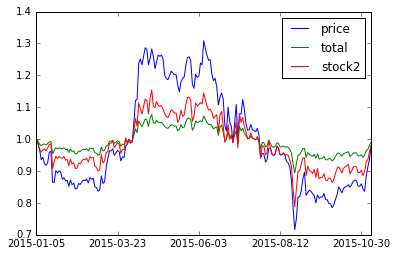

In [376]:
hcmp.plot()

In [377]:
hcmp

,price,total,stock2
2015-01-05,1.000000,1.000000,1.000000
2015-01-06,0.986175,0.993088,0.986175
2015-01-07,0.967742,0.983871,0.967742
2015-01-08,0.935484,0.979435,0.958871
2015-01-09,0.942857,0.983214,0.966429
2015-01-12,0.923502,0.984839,0.969677
2015-01-13,0.917972,0.981935,0.963871
2015-01-14,0.926267,0.986290,0.972581
2015-01-15,0.959447,0.991717,0.983433
2015-01-16,0.961290,0.992661,0.985323


In [364]:
data.head()
data[ (data['high']>10.87) & (data['low']<10.87)]

,open,high,close,low,volume,amount
date,,,,,,
2015-01-05,10.85,11.04,10.87,10.58,286043648.0,4.565388e+09
2015-01-06,10.75,11.12,10.70,10.55,216642144.0,3.453446e+09
2015-03-31,10.88,11.26,10.68,10.60,273318336.0,4.393135e+09
2015-04-01,10.73,10.95,10.83,10.55,164331648.0,2.608977e+09
2015-04-02,10.91,10.95,10.72,10.60,140583744.0,2.222671e+09
2015-06-29,11.56,11.62,11.13,10.47,261294320.0,3.570319e+09
2015-07-03,11.48,11.49,10.73,10.50,259745824.0,3.473336e+09
2015-07-07,11.22,12.03,12.03,10.85,480831200.0,6.808004e+09
2015-07-08,11.34,11.50,10.83,10.83,499669696.0,6.762103e+09


In [368]:
data['2015-01-06':'2015-11-09']

,open,high,close,low,volume,amount
date,,,,,,
2015-01-06,10.75,11.12,10.70,10.55,216642144.0,3.453446e+09
2015-01-07,10.55,10.74,10.50,10.38,170012064.0,2.634796e+09
2015-01-08,10.51,10.56,10.15,10.11,140771424.0,2.128003e+09
2015-01-09,10.11,10.76,10.23,9.98,250850016.0,3.835378e+09
2015-01-12,10.09,10.21,10.02,9.84,155329088.0,2.293105e+09
2015-01-13,9.94,10.11,9.96,9.91,81687480.0,1.204987e+09
2015-01-14,10.03,10.31,10.05,9.97,126302960.0,1.889297e+09
2015-01-15,10.07,10.41,10.41,9.98,124217032.0,1.868796e+09
2015-01-16,10.45,10.60,10.43,10.30,155584640.0,2.403346e+09


In [378]:
10.63/10.87

0.9779208831646735